# Image Transformation for Space Invaders

In [14]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

from skimage import io, color
from skimage.transform import resize
from skimage.draw import rectangle
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
import h5py

def load_transform(image_path):
    img = io.imread(image_path)
    img = img[25:195,10:150]
    img = resize(img, (60, 52), anti_aliasing=False)
    img = color.rgb2gray(img)
    img[img>=np.mean(img)] = 1
    img[img<np.mean(img)] = 0
    if np.mean(img) > 0.5:
        img = 1-img
    img_empty = np.zeros(img.shape)
    
    #thresh = threshold_otsu(img)
    #bw = closing(img > thresh, square(2))
    #cleared = bw
    #label_image = label(cleared)
    #for region in regionprops(label_image):
    #    if region.area >= 0 and region.area <= 70:
    #        minr, minc, maxr, maxc = region.bbox
            #rr, cc = rectangle(start=((minr+maxr)//2, (minc+maxc)//2), end=((minr+maxr)//2, (minc+maxc)//2), shape=img.shape)
            # print("rr: {}, cc: {}".format((minr+maxr)//2, (minc+maxc)//2))
    #        rr, cc = rectangle(start=(minr, minc), end=(maxr, maxc), shape=img.shape)
    #        img_empty[rr, cc] = 1

    #print(image_rescaled.shape)
    # image_reshaped = image_rescaled.reshape(3021)
    #img_empty[img_empty!=0] = 1
    return img

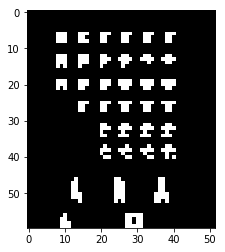

In [178]:
img = load_transform('E:\\spaceinvaders\\atari_v1\\screens\\spaceinvaders\\43\\{}.png'.format(3953))
plt.imshow(img, cmap=cm.gray)

In [114]:
np.mean(img)

0.06566176470588235

# Auto encoder definition

In [4]:
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
# encoding_dim = 256  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
def build_deep_net():
    # this is our input placeholder
    input_img = Input(shape=(3120,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(1560, activation='relu')(input_img)
    encoded = Dense(780, activation='relu')(encoded)
    encoded = Dense(224, activation='relu')(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(780, activation='relu')(encoded)
    decoded = Dense(1560, activation='relu')(decoded)
    decoded = Dense(3120, activation='sigmoid')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return encoder, autoencoder

Using plaidml.keras.backend backend.


In [5]:
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
# encoding_dim = 256  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
def build_simple_net():
    # this is our input placeholder
    input_img = Input(shape=(3120,))
    encoded = Dense(224, activation='relu')(input_img)
    decoded = Dense(3120, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return encoder, autoencoder

In [6]:
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

def build_conv_net():
    input_img = Input(shape=(60, 52, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(8, (8, 8), activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (8, 8), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(2, (8, 8), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(4, (8, 8), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (8, 8), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='valid')(x) 

    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return encoder, autoencoder

In [4]:
x_train = np.reshape(x_train, (len(x_train), 57, 53, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 57, 53, 1))  # adapt this if using `channels_first` image data format

NameError: name 'x_train' is not defined

# Image loading and transformation 

In [ ]:
from os import listdir, path, walk
import numpy as np
import h5py

data_path = 'E:\\spaceinvaders\\atari_v1\\screens\\spaceinvaders'

paths = listdir(data_path)
paths = [int(x) for x in paths]
paths.sort()
paths = [str(x) for x in paths]

for x in paths:
    print("loaded path: {}".format(x))
    current_path = path.join(data_path, x)
    image_paths = listdir(current_path)
    image_paths = [int(x[:-4]) for x in image_paths]
    image_paths.sort()
    image_paths = [str(x) + '.png' for x in image_paths]
    data_paths = [path.join(current_path, image) for image in image_paths]
    i = 0
    data = np.zeros(shape=(len(data_paths), 60, 52))
    for image in data_paths:
        data[i] = load_transform(image)
        i = i + 1
    data = data.reshape((len(data), np.prod(data.shape[1:])))
    print(data.shape)
    transformed_path = 'D:\\transformed_data_4\\space_invaders_{}.h5'.format(x)
    h5f = h5py.File(transformed_path)
    h5f.create_dataset('space_invaders', data=data)
    h5f.close()
    print("saved path: {}".format(transformed_path))


loaded path: 1
(1100, 3120)
saved path: D:\transformed_data_4\space_invaders_1.h5
loaded path: 2
(2669, 3120)
saved path: D:\transformed_data_4\space_invaders_2.h5
loaded path: 3
(3549, 3120)
saved path: D:\transformed_data_4\space_invaders_3.h5
loaded path: 4
(3325, 3120)
saved path: D:\transformed_data_4\space_invaders_4.h5
loaded path: 5
(4619, 3120)
saved path: D:\transformed_data_4\space_invaders_5.h5
loaded path: 6
(2507, 3120)
saved path: D:\transformed_data_4\space_invaders_6.h5
loaded path: 7
(1909, 3120)
saved path: D:\transformed_data_4\space_invaders_7.h5
loaded path: 8
(4694, 3120)
saved path: D:\transformed_data_4\space_invaders_8.h5
loaded path: 9
(3465, 3120)
saved path: D:\transformed_data_4\space_invaders_9.h5
loaded path: 10
(1426, 3120)
saved path: D:\transformed_data_4\space_invaders_10.h5
loaded path: 12
(5174, 3120)
saved path: D:\transformed_data_4\space_invaders_12.h5
loaded path: 13
(5064, 3120)
saved path: D:\transformed_data_4\space_invaders_13.h5
loaded pat

# Autoeconder training

In [1]:
import numpy as np

from os import listdir, path, walk, path
import numpy as np
import h5py
import re

regex = re.compile('\d+')

data_path = 'D:\\transformed_data_4'

paths = listdir(data_path)
numbers = [int(regex.findall(x.split('.')[0])[0]) for x in paths]
numbers.sort()
paths = ['{}{}{}'.format('space_invaders_', x, '.h5') for x in numbers]
dataset = np.zeros(shape=(0,3120))
i = 0
for x in paths:
    data = path.join(data_path, x)
    print("loaded path: {}".format(data))
    h5f = h5py.File(data, 'r')
    dataset =  np.vstack([dataset, h5f['space_invaders'][:]])
    i = i + 1
    if i >= 90:
        break
print(dataset.shape)

loaded path: D:\transformed_data_4\space_invaders_1.h5
loaded path: D:\transformed_data_4\space_invaders_2.h5
loaded path: D:\transformed_data_4\space_invaders_3.h5
loaded path: D:\transformed_data_4\space_invaders_4.h5
loaded path: D:\transformed_data_4\space_invaders_5.h5
loaded path: D:\transformed_data_4\space_invaders_6.h5
loaded path: D:\transformed_data_4\space_invaders_7.h5
loaded path: D:\transformed_data_4\space_invaders_8.h5
loaded path: D:\transformed_data_4\space_invaders_9.h5
loaded path: D:\transformed_data_4\space_invaders_10.h5
loaded path: D:\transformed_data_4\space_invaders_12.h5
loaded path: D:\transformed_data_4\space_invaders_13.h5
loaded path: D:\transformed_data_4\space_invaders_14.h5
loaded path: D:\transformed_data_4\space_invaders_15.h5
loaded path: D:\transformed_data_4\space_invaders_16.h5
loaded path: D:\transformed_data_4\space_invaders_17.h5
loaded path: D:\transformed_data_4\space_invaders_20.h5
loaded path: D:\transformed_data_4\space_invaders_21.h5
l

In [14]:
dataset = dataset.reshape(len(dataset), 3120)

In [12]:
num_to_load = len(dataset)
split = int(num_to_load * 0.8)


x_train = dataset[0:split]
x_test = dataset[split:]

# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(3015, 3120)
(754, 3120)


In [13]:
encoder, autoencoder = build_deep_net()

INFO:plaidml:Opening device "opencl_amd_hawaii.0"


In [87]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 60, 52, 1)         0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 60, 52, 8)         520       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 30, 26, 8)         0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 30, 26, 8)         4104      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 15, 13, 8)         0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 15, 13, 4)         2052      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 8, 7, 4)           0         
__________

In [14]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 3015 samples, validate on 754 samples
Epoch 1/50
3015/3015 [==============================] - 8s 3ms/step - loss: 0.6708 - val_loss: 0.5633
Epoch 2/50
3015/3015 [==============================] - 1s 374us/step - loss: 0.2390 - val_loss: 0.3138
Epoch 3/50
3015/3015 [==============================] - 1s 374us/step - loss: 0.2069 - val_loss: 0.3047
Epoch 4/50
3015/3015 [==============================] - 1s 374us/step - loss: 0.2047 - val_loss: 0.3050
Epoch 5/50
3015/3015 [==============================] - 1s 380us/step - loss: 0.2013 - val_loss: 0.3036
Epoch 6/50
3015/3015 [==============================] - 1s 381us/step - loss: 0.1926 - val_loss: 0.3050
Epoch 7/50
3015/3015 [==============================] - 1s 373us/step - loss: 0.1718 - val_loss: 0.2931
Epoch 8/50
3015/3015 [==============================] - 1s 374us/step - loss: 0.1540 - val_loss: 0.2887
Epoch 9/50
3015/3015 [==============================] - 1s 372us/step - loss: 0.1350 - val_loss: 0.2717
Epoch 10/50
3015/30

In [ ]:
autoenc

In [17]:
history = []

for i in range(0, 5):
    print("start: {}".format(i))
    # this is our input placeholder
    input_img = Input(shape=(3021,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(1510, activation='relu')(input_img)
    encoded = Dense(755, activation='relu')(encoded)
    encoded = Dense(100, activation='relu')(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(755, activation='relu')(encoded)
    decoded = Dense(1510, activation='relu')(decoded)
    decoded = Dense(3021, activation='sigmoid')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    print("training: {}".format(i))
    history.append(autoencoder.fit(x_train, x_train,
                                   epochs=25,
                                   batch_size=128,
                                   shuffle=True,
                                   validation_data=(x_test, x_test),
                                   verbose=0))
    print("done: {}".format(i))

start: 0
training: 0
done: 0
start: 1
training: 1
done: 1
start: 2
training: 2
done: 2
start: 3
training: 3
done: 3
start: 4
training: 4
done: 4


In [6]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [25]:
import matplotlib.pyplot as plt

def plot_history(history, name):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(name, bbox_inches='tight')
    plt.show()

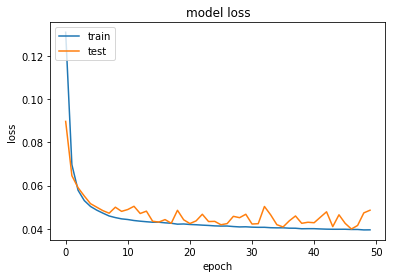

In [42]:
plot_history(history, 'D:\\results\\graphs\\conv_net_50_epoch_4.svg')

# Encode all images

In [1]:
from os import listdir, path, walk, path
import numpy as np
import h5py

data_path = '/media/andres/Baymax/transformed_data_2/'

from keras.models import load_model

model = load_model('/media/andres/Baymax/encoder100_6.h5')
paths = listdir(data_path)

for x in paths:
    print("loaded path: {}".format(x))
    current_path = path.join(data_path, x)
    h5f = h5py.File(current_path, 'r')
    data = h5f['space_invaders'][:]
    result = model.predict(data)
    print(result.shape)
    save_path = path.join('/media/andres/Baymax/encoded_100_6/', x)
    h5f = h5py.File(save_path)
    h5f.create_dataset('space_invaders', data=result)
    h5f.close()
    print("saved path: {}".format(save_path))


Using TensorFlow backend.
/home/andres/thesis_project/keras2/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


loaded path: space_invaders_1.h5
(1100, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_1.h5
loaded path: space_invaders_10.h5
(1426, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_10.h5
loaded path: space_invaders_101.h5
(4165, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_101.h5
loaded path: space_invaders_102.h5
(4749, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_102.h5
loaded path: space_invaders_103.h5
(3882, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_103.h5
loaded path: space_invaders_104.h5
(4897, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_104.h5
loaded path: space_invaders_105.h5
(3252, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_105.h5
loaded path: space_invaders_106.h5
(5055, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_106.h5
loaded path: space_invaders_107.h5
(7323, 100)
saved path: /media/andres/Bayma

(2732, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_90.h5
loaded path: space_invaders_93.h5
(3060, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_93.h5
loaded path: space_invaders_94.h5
(4300, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_94.h5
loaded path: space_invaders_95.h5
(4789, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_95.h5
loaded path: space_invaders_96.h5
(4863, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_96.h5
loaded path: space_invaders_114.h5
(3316, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_114.h5
loaded path: space_invaders_131.h5
(3970, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_131.h5
loaded path: space_invaders_150.h5
(3786, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_150.h5
loaded path: space_invaders_177.h5
(4648, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_177.h5


(5430, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_168.h5
loaded path: space_invaders_17.h5
(4000, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_17.h5
loaded path: space_invaders_178.h5
(3947, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_178.h5
loaded path: space_invaders_179.h5
(4227, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_179.h5
loaded path: space_invaders_180.h5
(3657, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_180.h5
loaded path: space_invaders_181.h5
(4852, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_181.h5
loaded path: space_invaders_182.h5
(4374, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_182.h5
loaded path: space_invaders_183.h5
(4601, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_183.h5
loaded path: space_invaders_186.h5
(322, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_1

(4798, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_267.h5
loaded path: space_invaders_268.h5
(4355, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_268.h5
loaded path: space_invaders_269.h5
(4561, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_269.h5
loaded path: space_invaders_27.h5
(458, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_27.h5
loaded path: space_invaders_270.h5
(3538, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_270.h5
loaded path: space_invaders_271.h5
(4012, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_271.h5
loaded path: space_invaders_273.h5
(3505, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_273.h5
loaded path: space_invaders_274.h5
(3978, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_274.h5
loaded path: space_invaders_275.h5
(5259, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_2

(3857, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_363.h5
loaded path: space_invaders_364.h5
(3662, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_364.h5
loaded path: space_invaders_365.h5
(3390, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_365.h5
loaded path: space_invaders_366.h5
(2309, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_366.h5
loaded path: space_invaders_367.h5
(4228, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_367.h5
loaded path: space_invaders_368.h5
(3546, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_368.h5
loaded path: space_invaders_369.h5
(3064, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_369.h5
loaded path: space_invaders_370.h5
(3351, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_370.h5
loaded path: space_invaders_371.h5
(1914, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invader

(3436, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_434.h5
loaded path: space_invaders_435.h5
(5178, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_435.h5
loaded path: space_invaders_436.h5
(5185, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_436.h5
loaded path: space_invaders_437.h5
(10254, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_437.h5
loaded path: space_invaders_438.h5
(6104, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_438.h5
loaded path: space_invaders_439.h5
(3387, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_439.h5
loaded path: space_invaders_44.h5
(2364, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_44.h5
loaded path: space_invaders_440.h5
(4050, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders_440.h5
loaded path: space_invaders_441.h5
(4622, 100)
saved path: /media/andres/Baymax/encoded_100_6/space_invaders

# Classifier

In [9]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
# encoding_dim = 256  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_array = Input(shape=(100,))
predictor = Dense(188, activation='relu')(input_array)
predictor = Dense(80, activation='tanh')(predictor)
predictor = Dense(18, activation='sigmoid')(predictor)

predictor_model = Model(input_array, predictor)
predictor_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

predictor_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 188)               18988     
_________________________________________________________________
dense_5 (Dense)              (None, 80)                15120     
_________________________________________________________________
dense_6 (Dense)              (None, 18)                1458      
Total params: 35,566
Trainable params: 35,566
Non-trainable params: 0
_________________________________________________________________


# Load Encoded Images

In [2]:
from os import listdir, path, walk, path
import numpy as np
import h5py
import re

regex = re.compile('\d+')

data_path = '/media/andres/Baymax/encoded_100/'

paths = listdir(data_path)
numbers = [int(regex.findall(x.split('.')[0])[0]) for x in paths]
numbers.sort()
paths = ['{}{}{}'.format('space_invaders_', x, '.h5') for x in numbers]
x_dataset = np.zeros(shape=(0,100))
i = 0
for x in paths:
    print("loaded path: {}".format(x))
    data = path.join(data_path, x)
    h5f = h5py.File(data, 'r')
    x_dataset =  np.vstack([x_dataset, h5f['space_invaders'][:]])
    i = i + 1
    if i >= 400:
        break
print(x_dataset.shape)


loaded path: space_invaders_1.h5
loaded path: space_invaders_2.h5
loaded path: space_invaders_3.h5
loaded path: space_invaders_4.h5
loaded path: space_invaders_5.h5
loaded path: space_invaders_6.h5
loaded path: space_invaders_7.h5
loaded path: space_invaders_8.h5
loaded path: space_invaders_9.h5
loaded path: space_invaders_10.h5
loaded path: space_invaders_12.h5
loaded path: space_invaders_13.h5
loaded path: space_invaders_14.h5
loaded path: space_invaders_15.h5
loaded path: space_invaders_16.h5
loaded path: space_invaders_17.h5
loaded path: space_invaders_20.h5
loaded path: space_invaders_21.h5
loaded path: space_invaders_22.h5
loaded path: space_invaders_23.h5
loaded path: space_invaders_27.h5
loaded path: space_invaders_32.h5
loaded path: space_invaders_33.h5
loaded path: space_invaders_34.h5
loaded path: space_invaders_35.h5
loaded path: space_invaders_36.h5
loaded path: space_invaders_37.h5
loaded path: space_invaders_38.h5
loaded path: space_invaders_39.h5
loaded path: space_inva

loaded path: space_invaders_305.h5
loaded path: space_invaders_306.h5
loaded path: space_invaders_308.h5
loaded path: space_invaders_309.h5
loaded path: space_invaders_310.h5
loaded path: space_invaders_311.h5
loaded path: space_invaders_312.h5
loaded path: space_invaders_313.h5
loaded path: space_invaders_314.h5
loaded path: space_invaders_315.h5
loaded path: space_invaders_316.h5
loaded path: space_invaders_317.h5
loaded path: space_invaders_318.h5
loaded path: space_invaders_319.h5
loaded path: space_invaders_322.h5
loaded path: space_invaders_323.h5
loaded path: space_invaders_324.h5
loaded path: space_invaders_325.h5
loaded path: space_invaders_327.h5
loaded path: space_invaders_328.h5
loaded path: space_invaders_329.h5
loaded path: space_invaders_330.h5
loaded path: space_invaders_331.h5
loaded path: space_invaders_332.h5
loaded path: space_invaders_333.h5
loaded path: space_invaders_334.h5
loaded path: space_invaders_335.h5
loaded path: space_invaders_336.h5
loaded path: space_i

In [4]:
import pandas as pd
import os
regex = re.compile('\d+')

data_path = '/media/andres/Data/spaceinvaders/atari_v1/trajectories/spaceinvaders'

paths = listdir(data_path)
numbers = [int(regex.findall(x.split('.')[0])[0]) for x in paths]
numbers.sort()
paths = ['{}.txt'.format(x, '.txt') for x in numbers]
y_dataset = np.zeros(shape=(0,18))
i = 0
for x in paths:
    print("loaded path: {}".format(x))
    full_path = os.path.join(data_path, x)
    data = pd.read_csv(full_path, skiprows=1)
    data.columns = ['frame', 'reward', 'score', 'terminal', 'action']
    a = data['action'].values
    b = np.zeros((a.size, 18))
    b[np.arange(a.size), a] = 1
    y_dataset = np.vstack([y_dataset, b])
    i = i + 1
    if i >= 400:
        break
print(y_dataset.shape)

loaded path: 1.txt
loaded path: 2.txt
loaded path: 3.txt
loaded path: 4.txt
loaded path: 5.txt
loaded path: 6.txt
loaded path: 7.txt
loaded path: 8.txt
loaded path: 9.txt
loaded path: 10.txt
loaded path: 12.txt
loaded path: 13.txt
loaded path: 14.txt
loaded path: 15.txt
loaded path: 16.txt
loaded path: 17.txt
loaded path: 20.txt
loaded path: 21.txt
loaded path: 22.txt
loaded path: 23.txt
loaded path: 27.txt
loaded path: 32.txt
loaded path: 33.txt
loaded path: 34.txt
loaded path: 35.txt
loaded path: 36.txt
loaded path: 37.txt
loaded path: 38.txt
loaded path: 39.txt
loaded path: 40.txt
loaded path: 41.txt
loaded path: 42.txt
loaded path: 43.txt
loaded path: 44.txt
loaded path: 45.txt
loaded path: 46.txt
loaded path: 48.txt
loaded path: 49.txt
loaded path: 50.txt
loaded path: 51.txt
loaded path: 52.txt
loaded path: 53.txt
loaded path: 54.txt
loaded path: 55.txt
loaded path: 56.txt
loaded path: 57.txt
loaded path: 58.txt
loaded path: 59.txt
loaded path: 60.txt
loaded path: 61.txt
loaded pa

loaded path: 482.txt
loaded path: 483.txt
loaded path: 484.txt
loaded path: 485.txt
(1679740, 18)


In [5]:
dataset = np.concatenate((x_dataset, y_dataset), axis=1)
dataset = dataset[dataset[:,100]!=1]

In [38]:
x_dataset[1]

array([5.25782805e-03, 1.79293447e-04, 2.19395396e-03, 0.00000000e+00,
       0.00000000e+00, 3.71869074e-03, 4.42519316e-04, 4.49822946e-03,
       0.00000000e+00, 2.65783479e-04, 0.00000000e+00, 9.66739245e-04,
       0.00000000e+00, 0.00000000e+00, 1.15660103e-02, 0.00000000e+00,
       6.03166821e-03, 1.73099263e-03, 4.04719723e-04, 0.00000000e+00,
       3.48786752e-04, 2.33124161e-03, 4.11155092e-03, 2.14975565e-03,
       1.25341617e-02, 4.11921235e-04, 8.37739723e-03, 5.75857714e-03,
       0.00000000e+00, 1.28161616e-03, 0.00000000e+00, 1.91045681e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.41570949e-04,
       3.34665024e-03, 2.11503599e-03, 1.56707564e-03, 1.57566155e-03,
       6.06701244e-03, 4.61040022e-04, 4.01883963e-03, 0.00000000e+00,
       3.24376944e-03, 3.85077608e-03, 2.35307400e-03, 2.78725517e-04,
       0.00000000e+00, 1.94225793e-03, 9.29612568e-04, 6.65205757e-03,
       3.53520184e-03, 2.07135721e-03, 7.22752495e-03, 3.44874429e-03,
      

In [6]:
datasets = np.split(dataset, [0,100], axis=1)
datasets[2].shape

x_dataset = datasets[1]
y_dataset = datasets[2]

for i in range(0, len(x_dataset)):
    x_dataset[i] = x_dataset[i]/x_dataset[i].sum()

x_dataset.shape

(885325, 100)

In [7]:
num_to_load = len(x_dataset)
split = int(num_to_load * 0.8)


x_train = x_dataset[0:split]
y_train = y_dataset[0:split]
x_test = x_dataset[split:]
y_test = y_dataset[split:]

# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
#print(x_train.shape)
#print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(708260, 18)
(177065, 18)


In [10]:
predictor_model.fit(x_train, y_train,
                epochs=40,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 708260 samples, validate on 177065 samples
Epoch 1/40
708260/708260 [==============================] - 24s 34us/step - loss: 1.2783 - acc: 0.4016 - val_loss: 1.2600 - val_acc: 0.4289
Epoch 2/40
708260/708260 [==============================] - 24s 33us/step - loss: 1.2224 - acc: 0.4608 - val_loss: 1.2386 - val_acc: 0.4525
Epoch 3/40
708260/708260 [==============================] - 24s 34us/step - loss: 1.1945 - acc: 0.4833 - val_loss: 1.2420 - val_acc: 0.4534
Epoch 4/40
708260/708260 [==============================] - 24s 33us/step - loss: 1.1766 - acc: 0.4948 - val_loss: 1.2293 - val_acc: 0.4632
Epoch 5/40
708260/708260 [==============================] - 24s 34us/step - loss: 1.1635 - acc: 0.5024 - val_loss: 1.2305 - val_acc: 0.4635
Epoch 6/40
708260/708260 [==============================] - 24s 34us/step - loss: 1.1531 - acc: 0.5081 - val_loss: 1.2345 - val_acc: 0.4682
Epoch 7/40
708260/708260 [==============================] - 24s 34us/step - loss: 1.1442 - acc: 0.5128 - val

In [11]:
predictor_model.save('/media/andres/Baymax/predictor_6.h5')

In [18]:


result = predictor_model.predict(np.array(x_test[0]))

print(result[0].argmax())
print(result[0])
print(result[0][result[0].argmax()])
print(result[0].max())

ValueError: Error when checking input: expected input_1 to have shape (100,) but got array with shape (1,)

In [ ]:
for i in to_remove:
    y_dataset = np.delete(y_dataset, i)
    x_dataset = np.delete(x_dataset, i)

In [14]:
import heapq

misses = 0
hits = 0

for i in range(0, len(result)):
    test = heapq.nlargest(3, range(0,len(result[i])), key=result[i].__getitem__)
    if y_test[i][test[0]] == 1 or y_test[i][test[1]] == 1 or y_test[i][test[2]] == 1:
        hits = hits + 1
    else:
        misses = misses + 1
        
print("hits: {}".format(hits))
print("misses: {}".format(misses))
print("precission: {}".format(hits/(hits+misses)))

hits: 162154
misses: 14911
precission: 0.9157879874622313


In [7]:
total = len(y_dataset)
for i in range(0, 18):
    count = 0
    for y in y_dataset:
        if y[i] == 1:
            count = count + 1
    print("total samples of class {}: {} - {:.2f}%".format(i, count, (count/total)*100))

total samples of class 0: 0 - 0.00%
total samples of class 1: 91671 - 27.99%
total samples of class 2: 404 - 0.12%
total samples of class 3: 121747 - 37.18%
total samples of class 4: 93824 - 28.65%
total samples of class 5: 106 - 0.03%
total samples of class 6: 52 - 0.02%
total samples of class 7: 30 - 0.01%
total samples of class 8: 25 - 0.01%
total samples of class 9: 6 - 0.00%
total samples of class 10: 23 - 0.01%
total samples of class 11: 11186 - 3.42%
total samples of class 12: 8363 - 2.55%
total samples of class 13: 1 - 0.00%
total samples of class 14: 0 - 0.00%
total samples of class 15: 0 - 0.00%
total samples of class 16: 58 - 0.02%
total samples of class 17: 0 - 0.00%


In [8]:
total = len(y_train)
for i in range(0, 18):
    count = 0
    for y in y_train:
        if y[i] == 1:
            count = count + 1
    print("total samples of class {}: {} - {:.2f}%".format(i, count, (count/total)*100))

total samples of class 0: 0 - 0.00%
total samples of class 1: 71261 - 27.20%
total samples of class 2: 348 - 0.13%
total samples of class 3: 98568 - 37.62%
total samples of class 4: 75975 - 29.00%
total samples of class 5: 79 - 0.03%
total samples of class 6: 50 - 0.02%
total samples of class 7: 30 - 0.01%
total samples of class 8: 18 - 0.01%
total samples of class 9: 6 - 0.00%
total samples of class 10: 5 - 0.00%
total samples of class 11: 8966 - 3.42%
total samples of class 12: 6631 - 2.53%
total samples of class 13: 1 - 0.00%
total samples of class 14: 0 - 0.00%
total samples of class 15: 0 - 0.00%
total samples of class 16: 58 - 0.02%
total samples of class 17: 0 - 0.00%


In [19]:
total = len(y_test)
for i in range(0, 18):
    count = 0
    for y in y_test:
        if y[i] == 1:
            count = count + 1
    print("total samples of class {}: {} - {:.2f}%".format(i, count, (count/total)*100))

total samples of class 0: 166017 - 47.00%
total samples of class 1: 60981 - 17.26%
total samples of class 2: 105 - 0.03%
total samples of class 3: 64044 - 18.13%
total samples of class 4: 48614 - 13.76%
total samples of class 5: 27 - 0.01%
total samples of class 6: 24 - 0.01%
total samples of class 7: 2 - 0.00%
total samples of class 8: 15 - 0.00%
total samples of class 9: 1 - 0.00%
total samples of class 10: 0 - 0.00%
total samples of class 11: 7898 - 2.24%
total samples of class 12: 5485 - 1.55%
total samples of class 13: 3 - 0.00%
total samples of class 14: 0 - 0.00%
total samples of class 15: 0 - 0.00%
total samples of class 16: 0 - 0.00%
total samples of class 17: 0 - 0.00%


In [52]:
len(sequence_train.paths) + len(sequence_validation.paths)

1766078

In [ ]:
autoencoder.fit_generator(generator=sequence_train, 
                          epochs=80,
                          validation_data=sequence_validation,
                          max_queue_size=10,
                          workers=4,
                          use_multiprocessing=True)


Epoch 1/80


/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transf

  12/1379 [..............................] - ETA: 17:10:05 - loss: 0.6909

In [17]:
predictor_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 377)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 188)               71064     
_________________________________________________________________
dense_2 (Dense)              (None, 47)                8883      
_________________________________________________________________
dense_3 (Dense)              (None, 18)                864       
Total params: 80,811
Trainable params: 80,811
Non-trainable params: 0
_________________________________________________________________


In [74]:
len(a)

377

In [3]:
import numpy as np
from random import randint
train_x = np.random.rand(10000,377)
train_y = np.zeros((10000, 18))

In [4]:
for row in train_y:
    row[0] = 1

In [77]:
train_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [11]:
predictor_model.fit(train_x, train_y,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(train_x, train_y))

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 2s 190us/step - loss: 8.8349e-04 - val_loss: 1.6077e-06
Epoch 2/50
10000/10000 [==============================] - 2s 175us/step - loss: 1.0824e-06 - val_loss: 7.6943e-07
Epoch 3/50
10000/10000 [==============================] - 2s 174us/step - loss: 6.2807e-07 - val_loss: 5.2232e-07
Epoch 4/50
10000/10000 [==============================] - 2s 180us/step - loss: 4.5799e-07 - val_loss: 4.0547e-07
Epoch 5/50
10000/10000 [==============================] - 2s 171us/step - loss: 3.6890e-07 - val_loss: 3.3763e-07
Epoch 6/50
10000/10000 [==============================] - 2s 175us/step - loss: 3.1426e-07 - val_loss: 2.9366e-07
Epoch 7/50
10000/10000 [==============================] - 2s 172us/step - loss: 2.7738e-07 - val_loss: 2.6272e-07
Epoch 8/50
10000/10000 [==============================] - 2s 166us/step - loss: 2.5080e-07 - val_loss: 2.3994e-07
Epoch 9/50
10000/10000 [==============

In [12]:
result = predictor_model.predict(train_x)

In [13]:
result[0]

array([ 0.9999999 , -0.52402663, -0.78376174, -0.99066645, -0.82346517,
       -0.7911382 , -0.8860826 , -0.8925584 , -0.86585486, -0.7716998 ,
       -0.9347379 , -0.7225369 , -0.9952648 , -0.46945217, -0.9444944 ,
       -0.92316824, -0.9827192 , -0.8370023 ], dtype=float32)

In [54]:
train_y[0]

array([11.])

In [29]:
a

array([0.96464172, 0.0374102 , 0.06367769, 0.43808396, 0.33149993,
       0.6639806 , 0.89277104, 0.67845068, 0.3646353 , 0.25952953,
       0.26613748, 0.35238901, 0.64176481, 0.45047746, 0.56789687,
       0.00919414, 0.1303084 , 0.72539952, 0.3321035 , 0.88052515,
       0.34029707, 0.50018285, 0.2087765 , 0.26215716, 0.22870178,
       0.23009559, 0.45292584, 0.70454599, 0.87002428, 0.34197075,
       0.13441189, 0.22718142, 0.71868584, 0.33989796, 0.54064392,
       0.87639121, 0.8484391 , 0.67377135, 0.57060809, 0.68338729,
       0.02014656, 0.47815473, 0.92303769, 0.24825419, 0.27910188,
       0.79125838, 0.51276072, 0.21473458, 0.6918284 , 0.55021233,
       0.2991266 , 0.53690291, 0.50489642, 0.80614165, 0.79154076,
       0.15664683, 0.02441173, 0.93479568, 0.53164814, 0.26176709,
       0.25848321, 0.16895805, 0.55590089, 0.13986689, 0.86039142,
       0.14204966, 0.79149357, 0.79116753, 0.57280507, 0.35333719,
       0.58120717, 0.22440114, 0.37798431, 0.5543642 , 0.29560

In [21]:
len(['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'])

18

In [23]:
result = autoencoder.predict(np.expand_dims(dataset[9], axis=0))[0]

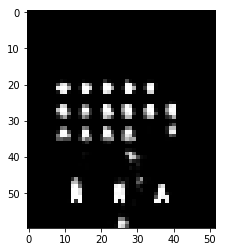

In [24]:
plt.imshow(result.reshape(60, 52), cmap=cm.gray)

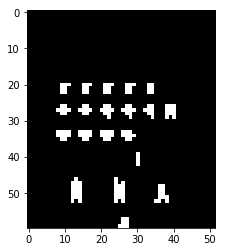

In [25]:
plt.imshow(dataset[9].reshape(60, 52), cmap=cm.gray)

In [30]:
b

array([[1, 0, 0],
       [0, 1, 0]])

In [36]:
result = np.concatenate((a,b), axis=1)

In [52]:
result[result[:,3]!=1]

array([[1, 2, 3, 0, 1, 0]])

In [42]:
a[a[:,0] > 3]

[[ 1  0  5  7  8]
 [11 13 15 17 18]]


In [5]:
import itertools
import random
factors = {
    'names': ['net_type', 'batch_size'],
    'net_type': [build_conv_net, build_deep_net, build_simple_net],
    'batch_size': [64, 128]
}

def generate_experiments(factors, repetitions):
    randomized = []
    for factor_name in factors['names']:
        randomized.append(factors[factor_name])
    experiments_permutations = list(itertools.product(*randomized))*repetitions
    return random.sample(experiments_permutations, len(experiments_permutations))

In [6]:
import h5py
import numpy as np

i = 0
for experiment in generate_experiments(factors, 4):
    print("Running experiment: {} - net: {} batch_size: {}".format(i, experiment[0].__name__, experiment[1]))
    # Reshape
    if experiment[0] == build_conv_net:
        dataset = dataset.reshape(len(dataset), 60, 52, 1)
    else:
        dataset = dataset.reshape(len(dataset), 3120)
    np.random.shuffle(dataset)
    # Split
    num_to_load = len(dataset)
    split = int(num_to_load * 0.8)
    x_train = dataset[0:split]
    x_test = dataset[split:]
    encoder, autoencoder = experiment[0]()
    # train
    history = autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=experiment[1],
                shuffle=True,
                validation_data=(x_test, x_test))
    h5f = h5py.File('D:\\results\\experiments_data\\{}_{}_{}.h5'.format(experiment[0].__name__, experiment[1], i))
    h5f.create_dataset('val_loss', data=history.history['val_loss'])
    h5f.create_dataset('loss', data=history.history['loss'])
    h5f.close()
    i = i + 1

Running experiment: 0 - net: build_deep_net batch_size: 128


INFO:plaidml:Opening device "opencl_amd_hawaii.0"


Train on 255721 samples, validate on 63931 samples
Epoch 1/30
255721/255721 [==============================] - 107s 418us/step - loss: 0.1315 - val_loss: 0.0786
Epoch 2/30
255721/255721 [==============================] - 101s 394us/step - loss: 0.0678 - val_loss: 0.0621
Epoch 3/30
255721/255721 [==============================] - 100s 393us/step - loss: 0.5337 - val_loss: 0.6101
Epoch 4/30
255721/255721 [==============================] - 100s 392us/step - loss: 0.5685 - val_loss: 0.5312
Epoch 5/30
255721/255721 [==============================] - 101s 396us/step - loss: 0.5005 - val_loss: 0.4730
Epoch 6/30
255721/255721 [==============================] - 98s 382us/step - loss: 0.4499 - val_loss: 0.4295
Epoch 7/30
255721/255721 [==============================] - 100s 390us/step - loss: 0.4117 - val_loss: 0.3962
Epoch 8/30
255721/255721 [==============================] - 99s 388us/step - loss: 0.3823 - val_loss: 0.3705
Epoch 9/30
255721/255721 [==============================] - 100s 391us/

INFO:plaidml:Analyzing Ops: 105 of 431 operations complete


255721/255721 [==============================] - 141s 550us/step - loss: 0.1301 - val_loss: 0.0749
Epoch 2/30
255721/255721 [==============================] - 123s 482us/step - loss: 0.0676 - val_loss: 0.0594
Epoch 3/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0575 - val_loss: 0.0556
Epoch 4/30
255721/255721 [==============================] - 123s 479us/step - loss: 0.0527 - val_loss: 0.0548
Epoch 5/30
255721/255721 [==============================] - 124s 484us/step - loss: 0.0501 - val_loss: 0.0475
Epoch 6/30
255721/255721 [==============================] - 124s 484us/step - loss: 0.0484 - val_loss: 0.0454
Epoch 7/30
255721/255721 [==============================] - 123s 482us/step - loss: 0.0471 - val_loss: 0.0484
Epoch 8/30
255721/255721 [==============================] - 123s 482us/step - loss: 0.0462 - val_loss: 0.0466
Epoch 9/30
255721/255721 [==============================] - 123s 482us/step - loss: 0.0451 - val_loss: 0.0459
Epoch 10/30
255721/25

INFO:plaidml:Analyzing Ops: 367 of 431 operations complete


255721/255721 [==============================] - 160s 627us/step - loss: 0.1107 - val_loss: 0.0627
Epoch 2/30
255721/255721 [==============================] - 143s 559us/step - loss: 0.0608 - val_loss: 0.0620
Epoch 3/30
255721/255721 [==============================] - 142s 557us/step - loss: 0.0531 - val_loss: 0.0500
Epoch 4/30
255721/255721 [==============================] - 142s 556us/step - loss: 0.0489 - val_loss: 0.0456
Epoch 5/30
255721/255721 [==============================] - 142s 557us/step - loss: 0.0457 - val_loss: 0.0447
Epoch 6/30
255721/255721 [==============================] - 143s 558us/step - loss: 0.0437 - val_loss: 0.0401
Epoch 7/30
255721/255721 [==============================] - 143s 559us/step - loss: 0.0422 - val_loss: 0.0424
Epoch 8/30
255721/255721 [==============================] - 143s 559us/step - loss: 0.0412 - val_loss: 0.0410
Epoch 9/30
255721/255721 [==============================] - 143s 560us/step - loss: 0.0402 - val_loss: 0.0387
Epoch 10/30
255721/25

INFO:plaidml:Analyzing Ops: 105 of 431 operations complete


255721/255721 [==============================] - 138s 540us/step - loss: 0.1264 - val_loss: 0.0747
Epoch 2/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0654 - val_loss: 0.0627
Epoch 3/30
255721/255721 [==============================] - 122s 479us/step - loss: 0.0560 - val_loss: 0.0540
Epoch 4/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0519 - val_loss: 0.0463
Epoch 5/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0495 - val_loss: 0.0439
Epoch 6/30
255721/255721 [==============================] - 123s 479us/step - loss: 0.0471 - val_loss: 0.0520
Epoch 7/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0460 - val_loss: 0.0428
Epoch 8/30
255721/255721 [==============================] - 123s 479us/step - loss: 0.0445 - val_loss: 0.0409
Epoch 9/30
255721/255721 [==============================] - 123s 479us/step - loss: 0.0438 - val_loss: 0.0413
Epoch 10/30
255721/25

255721/255721 [==============================] - 143s 559us/step - loss: 1.3341 - val_loss: 1.3183
Epoch 26/30
255721/255721 [==============================] - 143s 558us/step - loss: 1.3341 - val_loss: 1.3183
Epoch 27/30
255721/255721 [==============================] - 143s 558us/step - loss: 1.3341 - val_loss: 1.3183
Epoch 28/30
255721/255721 [==============================] - 142s 557us/step - loss: 1.3341 - val_loss: 1.3183
Epoch 29/30
255721/255721 [==============================] - 143s 557us/step - loss: 1.3341 - val_loss: 1.3183
Epoch 30/30
255721/255721 [==============================] - 142s 557us/step - loss: 1.3341 - val_loss: 1.3183
Running experiment: 12 - net: build_conv_net batch_size: 64
Train on 255721 samples, validate on 63931 samples
Epoch 1/30
255721/255721 [==============================] - 143s 559us/step - loss: 0.0993 - val_loss: 0.0653
Epoch 2/30
255721/255721 [==============================] - 142s 557us/step - loss: 0.0541 - val_loss: 0.0492
Epoch 3/30
2557

255721/255721 [==============================] - 123s 481us/step - loss: 0.0491 - val_loss: 0.0460
Epoch 7/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0474 - val_loss: 0.0498
Epoch 8/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0462 - val_loss: 0.0456
Epoch 9/30
255721/255721 [==============================] - 123s 482us/step - loss: 0.0451 - val_loss: 0.0455
Epoch 10/30
255721/255721 [==============================] - 122s 479us/step - loss: 0.0443 - val_loss: 0.0448
Epoch 11/30
255721/255721 [==============================] - 122s 479us/step - loss: 0.0436 - val_loss: 0.0409
Epoch 12/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0429 - val_loss: 0.0437
Epoch 13/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0422 - val_loss: 0.0400
Epoch 14/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0416 - val_loss: 0.0403
Epoch 15/30
2557

INFO:plaidml:Analyzing Ops: 367 of 431 operations complete


255721/255721 [==============================] - 140s 548us/step - loss: 0.1450 - val_loss: 0.0812
Epoch 2/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0658 - val_loss: 0.0590
Epoch 3/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0552 - val_loss: 0.0507
Epoch 4/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0504 - val_loss: 0.0491
Epoch 5/30
255721/255721 [==============================] - 123s 480us/step - loss: 0.0477 - val_loss: 0.0485
Epoch 6/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0457 - val_loss: 0.0456
Epoch 7/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0443 - val_loss: 0.0441
Epoch 8/30
255721/255721 [==============================] - 123s 481us/step - loss: 0.0428 - val_loss: 0.0412
Epoch 9/30
255721/255721 [==============================] - 123s 479us/step - loss: 0.0419 - val_loss: 0.0398
Epoch 10/30
255721/25

255721/255721 [==============================] - 30s 116us/step - loss: 0.2547 - val_loss: 0.2542
Epoch 26/30
255721/255721 [==============================] - 30s 116us/step - loss: 0.2531 - val_loss: 0.2526
Epoch 27/30
255721/255721 [==============================] - 30s 116us/step - loss: 0.2516 - val_loss: 0.2513
Epoch 28/30
255721/255721 [==============================] - 30s 116us/step - loss: 0.2503 - val_loss: 0.2500
Epoch 29/30
255721/255721 [==============================] - 30s 118us/step - loss: 0.2491 - val_loss: 0.2488
Epoch 30/30
255721/255721 [==============================] - 30s 117us/step - loss: 0.2479 - val_loss: 0.2478
Running experiment: 23 - net: build_simple_net batch_size: 64
Train on 255721 samples, validate on 63931 samples
Epoch 1/30
255721/255721 [==============================] - 45s 175us/step - loss: 0.1333 - val_loss: 0.0787
Epoch 2/30
255721/255721 [==============================] - 43s 168us/step - loss: 0.0674 - val_loss: 0.0580
Epoch 3/30
255721/255

In [4]:
build_conv_net()[1].summary()

INFO:plaidml:Opening device "opencl_amd_hawaii.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 52, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 52, 8)         520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 26, 8)         4104      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 13, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 13, 2)         1026      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 7, 2)           0         
__________

In [5]:
build_deep_net()[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3120)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1560)              4868760   
_________________________________________________________________
dense_2 (Dense)              (None, 780)               1217580   
_________________________________________________________________
dense_3 (Dense)              (None, 224)               174944    
_________________________________________________________________
dense_4 (Dense)              (None, 780)               175500    
_________________________________________________________________
dense_5 (Dense)              (None, 1560)              1218360   
_________________________________________________________________
dense_6 (Dense)              (None, 3120)              4870320   
Total para

In [10]:
build_simple_net()[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3120)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 224)               699104    
_________________________________________________________________
dense_11 (Dense)             (None, 3120)              702000    
Total params: 1,401,104
Trainable params: 1,401,104
Non-trainable params: 0
_________________________________________________________________


In [7]:
import numpy as np
import os
import h5py

path = "D:\\results\\experiments_data\\"
files = os.listdir(path)

conv_128 = [path + file for file in files if 'conv_net_128' in file]
conv_64 = [path + file for file in files if 'conv_net_64' in file]

deep_128 = [path + file for file in files if 'deep_net_128' in file]
deep_64 = [path + file for file in files if 'deep_net_64' in file]

simple_128 = [path + file for file in files if 'simple_net_128' in file]
simple_64 = [path + file for file in files if 'simple_net_64' in file]

In [21]:
def avg_h5py(list_of_files):
    loss = np.zeros((len(list_of_files), 30))
    val_loss = np.zeros((len(list_of_files), 30))
    for i in range(0, len(list_of_files)):
        loss[i] = h5py.File(list_of_files[i], 'r')['loss']
        val_loss[i] = h5py.File(list_of_files[i], 'r')['val_loss']
        return np.mean(loss, axis=0), np.mean(val_loss, axis=0)

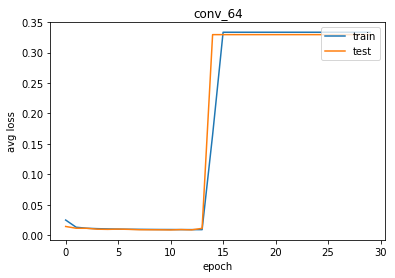

loss min: 0.009006360539228061 at epoch: 14
val_loss min: 0.008565520530858246 at epoch: 11


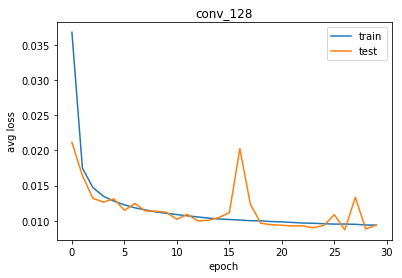

loss min: 0.00938949703388199 at epoch: 30
val_loss min: 0.008712826753964748 at epoch: 27


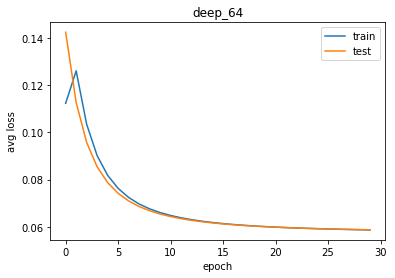

loss min: 0.05870854213072088 at epoch: 30
val_loss min: 0.05875367279504662 at epoch: 30


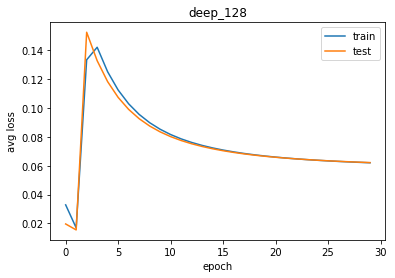

loss min: 0.016960288159045104 at epoch: 2
val_loss min: 0.015516104998064953 at epoch: 2


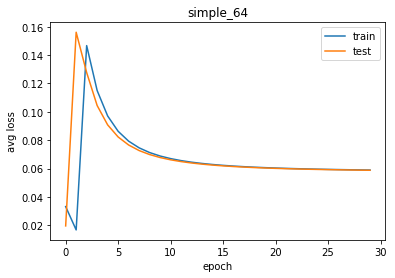

loss min: 0.016783708503536027 at epoch: 2
val_loss min: 0.01961068443889194 at epoch: 1


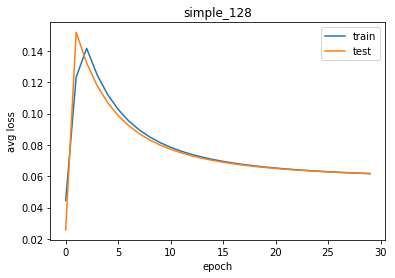

loss min: 0.04442331105236174 at epoch: 1
val_loss min: 0.02568934154313707 at epoch: 1


In [32]:
list_results = [conv_64, conv_128, deep_64, deep_128, simple_64, simple_128]
list_results_names = ['conv_64', 'conv_128', 'deep_64', 'deep_128', 'simple_64', 'simple_128']

for i in range(0, len(list_results)):
    loss, val_loss = avg_h5py(list_results[i])
    plot_history(loss, val_loss, list_results_names[i])
    print("loss min: {} at epoch: {}".format(np.amin(loss), np.argmin(loss)+1))
    print("val_loss min: {} at epoch: {}".format(np.amin(val_loss), np.argmin(val_loss)+1))

In [10]:
import matplotlib.pyplot as plt
import os

def plot_history(loss, val_loss, name):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(name)
    plt.ylabel('avg loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(os.path.join("D:\\results\\graphs", "{}.svg".format(name)), bbox_inches='tight')
    plt.show()

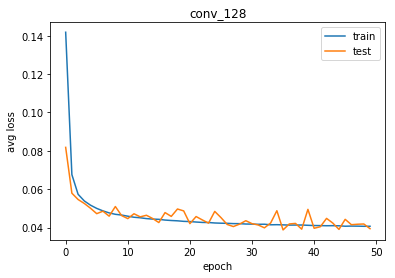

In [11]:
plot_history(history.history['loss'], history.history['val_loss'], 'conv_128')

In [25]:
conv_128.__name__

AttributeError: 'list' object has no attribute '__name__'

In [27]:
np.argmin(np.zeros)

0

In [7]:
encoder, autoencoder = build_conv_net()

INFO:plaidml:Opening device "opencl_amd_hawaii.0"


In [ ]:
#dataset = dataset.reshape(len(dataset), 60, 52, 1)
#np.random.shuffle(dataset)

#num_to_load = len(dataset)
#split = int(num_to_load * 0.8)
#x_train = dataset[0:split]
#x_test = dataset[split:]

history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Train on 288680 samples, validate on 72171 samples
Epoch 1/50
288680/288680 [==============================] - 139s 480us/step - loss: 0.0406 - val_loss: 0.0393
Epoch 2/50
288680/288680 [==============================] - 139s 482us/step - loss: 0.0404 - val_loss: 0.0435
Epoch 3/50
288680/288680 [==============================] - 138s 479us/step - loss: 0.0404 - val_loss: 0.0434
Epoch 4/50
288680/288680 [==============================] - 138s 479us/step - loss: 0.0404 - val_loss: 0.0375
Epoch 5/50
288680/288680 [==============================] - 141s 488us/step - loss: 0.0403 - val_loss: 0.0431
Epoch 6/50
288680/288680 [==============================] - 138s 479us/step - loss: 0.0403 - val_loss: 0.0391
Epoch 7/50
288680/288680 [==============================] - 139s 481us/step - loss: 0.0403 - val_loss: 0.0389
Epoch 8/50
288680/288680 [==============================] - 139s 483us/step - loss: 0.0403 - val_loss: 0.0402
Epoch 9/50
288680/288680 [==============================] - 138s 480u

In [26]:
encoder.save('D:\\conv_encoder_50_128_2.h5')
autoencoder.save('D:\\conv_autoencoder_50_128_2.h5')